## The Model

from : https://www.tensorflow.org/probability/examples/Probabilistic_PCA

Probabilistic principal components analysis (PCA) is a
dimensionality reduction technique that
analyzes data via a lower dimensional latent space
([Tipping and Bishop 1999](#1)). It is often
used when there are missing values in the data or for multidimensional
scaling.


Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

$$
\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}
$$

The corresponding data point is generated via a projection,

$$
\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}
$$

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

$$
\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}).
\end{equation*}
$$

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we assume $\sigma$ is known, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes.

# Simulation

In [1]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
import matplotlib.pyplot as plt
from jax import vmap
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
m = bi(platform='cpu')



# --- 1. Define and Generate the Hierarchical Data ---
# (This part is correct and remains unchanged)
def sim_data_hierarchical(data_dim, num_datapoints, stddv_datapoints, seed=0):
    latent_dim = 4
    latent_scales = jnp.array([10.0, 5.0, 2.0, 0.5])
    w = m.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w', sample=True, seed=seed)
    z = m.dist.normal(0, 1, shape=(latent_dim, num_datapoints), name='z', sample=True, seed=seed)
    z_scaled = z * latent_scales[:, None]
    x = m.dist.normal(w @ z_scaled, stddv_datapoints, name='x', sample=True, seed=seed)
    return w, z_scaled, x

num_datapoints = 500
data_dim = 4
stddv_datapoints = 0.5
actual_w_h, actual_z_h, x_train_h = sim_data_hierarchical(data_dim, num_datapoints, stddv_datapoints, seed=20)

jax.local_device_count 16


## Model

In [2]:


# Model using simulated data
#def model(x_train, data_dim, latent_dim, num_datapoints): 
#    w = m.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w')
#    z = m.dist.normal(0, 1, shape=(latent_dim, num_datapoints), name='z')
#    epsilon = m.dist.exponential(1, name='epsilon')
#    m.dist.normal(w @ z , epsilon, obs = x_train)  



In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# --- 1. Define and Generate the Hierarchical Data ---
# (This part is correct and remains unchanged)
def sim_data_hierarchical(data_dim, num_datapoints, stddv_datapoints, seed=0):
    latent_dim = 4
    latent_scales = jnp.array([10.0, 5.0, 2.0, 0.5])
    w = m.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w', sample=True, seed=seed)
    z = m.dist.normal(0, 1, shape=(latent_dim, num_datapoints), name='z', sample=True, seed=seed)
    z_scaled = z * latent_scales[:, None]
    x = m.dist.normal(w @ z_scaled, stddv_datapoints, name='x', sample=True, seed=seed)
    return w, z_scaled, x

num_datapoints = 500
data_dim = 4
stddv_datapoints = 0.5
actual_w_h, actual_z_h, x_train_h = sim_data_hierarchical(data_dim, num_datapoints, stddv_datapoints, seed=20)



In [4]:

# --- 2. THE FINAL CORRECTED MODEL DEFINITION ---
def model_final(x_train, data_dim, latent_dim, num_datapoints):
    """
    Probabilistic PCA model with ARD (Automatic Relevance Determination) prior on weights and a correctly defined noise model. ARD helps in automatic relevance determination of latent dimensions, by allowing the model to learn which dimensions are important.
    Args:
        x_train: Observed data matrix of shape (data_dim, num_datapoints).
        data_dim: Dimensionality of the observed data.
        latent_dim: Dimensionality of the latent space.
        num_datapoints: Number of data points.
    """
    # ARD Prior on w (This part is correct)
    alpha = m.dist.gamma(.05, 1e-3, shape=(latent_dim,), name='alpha')
    w = m.dist.normal(0, 1. / jnp.sqrt(alpha)[None, :], shape=(data_dim, latent_dim), name='w')

    # Prior on z (This part is correct)
    z = m.dist.normal(0, 1., shape=(latent_dim, num_datapoints), name='z')

    # --- CORRECTED NOISE MODEL ---
    # Prior on the precision (1 / variance)
    precision = m.dist.gamma(1.0, 1.0, name='precision')
    # The standard deviation is 1 / sqrt(precision)
    stddv = 1. / jnp.sqrt(precision)

    # Use the correctly defined standard deviation in the likelihood
    m.dist.normal(w @ z, stddv, obs=x_train)



sample: 100%|██████████| 1000/1000 [00:35<00:00, 28.24it/s, 255 steps of size 2.09e-02. acc. prob=0.83]
/tmp/ipykernel_80860/3644858733.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


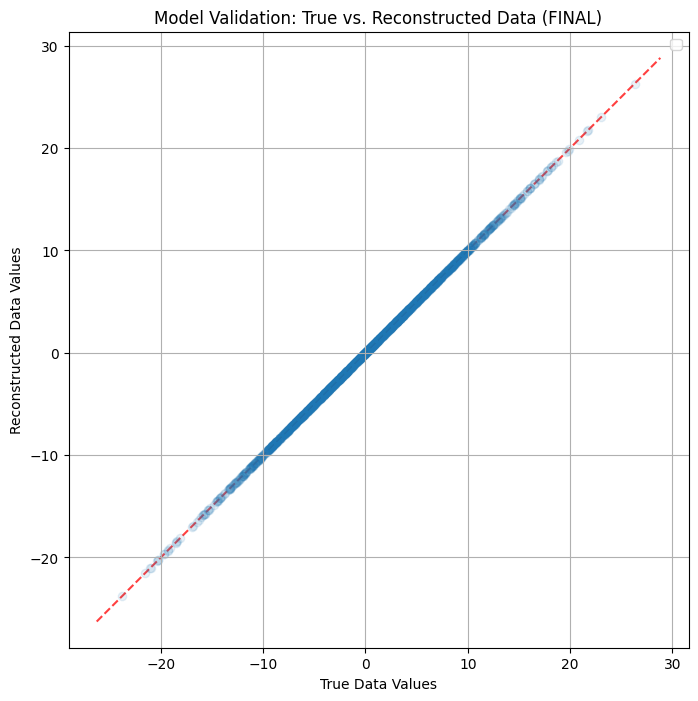

True noise standard deviation: 0.5
Inferred noise standard deviation: 0.0636


In [5]:

# --- 3. Fit the Final Model ---
m.data_on_model = dict(
    x_train=x_train_h,
    data_dim=data_dim,
    latent_dim=4,
    num_datapoints=num_datapoints
)
m.fit(model_final)

# --- 4. Correctly Calculate and Plot the Reconstruction ---
# (This logic was already correct from the previous step)
w_samples = m.posteriors['w']
z_samples = m.posteriors['z']

reconstruct_one_sample = lambda w, z: w @ z
x_reconstructed_samples = jax.vmap(reconstruct_one_sample)(w_samples, z_samples)
x_reconstructed_correct = x_reconstructed_samples.mean(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(x_train_h.flatten(), x_reconstructed_correct.flatten(), alpha=0.1)
x_lims, y_lims = plt.xlim(), plt.ylim()
all_lims = jnp.array([x_lims, y_lims])
lims = [jnp.min(all_lims), jnp.max(all_lims)]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
plt.xlabel("True Data Values")
plt.ylabel("Reconstructed Data Values")
plt.title("Model Validation: True vs. Reconstructed Data (FINAL)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Optional: Check if the model learned the correct noise level
posterior_stddv = 1. / jnp.sqrt(m.posteriors['precision'].mean())
print(f"True noise standard deviation: {stddv_datapoints}")
print(f"Inferred noise standard deviation: {posterior_stddv:.4f}")

# Estimations are inverted due to **Sign Ambiguity in PCA**: 



Principal Component Analysis (PCA) identifies directions (principal components) that capture the maximum variance in the data. However, the orientation of these components is not unique; both a vector and its negation represent the same principal direction. This means that if 𝑤 is a principal component, −𝑤 is equally valid.

To resolve this issue, we can align the signs of the estimated parameters with the true parameters before comparison. 

Compute the Dot Product: Calculate the dot product between the true parameters and the estimated parameters. This will help determine the relative orientation.

Align Signs: If the dot product is negative, multiply the estimated parameters by -1 to align them with the true parameters.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


true_params = jnp.array(real_data)      
estimated_params = jnp.array(posteriors)

# Compute dot product
dot_product = jnp.dot(true_params, estimated_params)

# Align signs if necessary
if dot_product < 0:
    estimated_params = -estimated_params

# Plot the aligned parameters
plt.scatter(true_params, estimated_params, alpha=0.7)
plt.plot([min(true_params), max(true_params)], [min(true_params), max(true_params)], 'r--')
plt.xlabel('True Parameters')
plt.ylabel('Estimated Parameters')
plt.title('True vs. Estimated Parameters After Sign Alignment')
plt.show()

# Iris data

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:11<00:00, 88.99it/s, 127 steps of size 3.34e-02. acc. prob=0.88]
/home/sosa/work/BI/BI/Models/PCA.py:417: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(indices, cumulative, 'ro-', color=color_cumulative_line, label='Cumulative explained variance')
/home/sosa/work/BI/BI/Models/PCA.py:753: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle


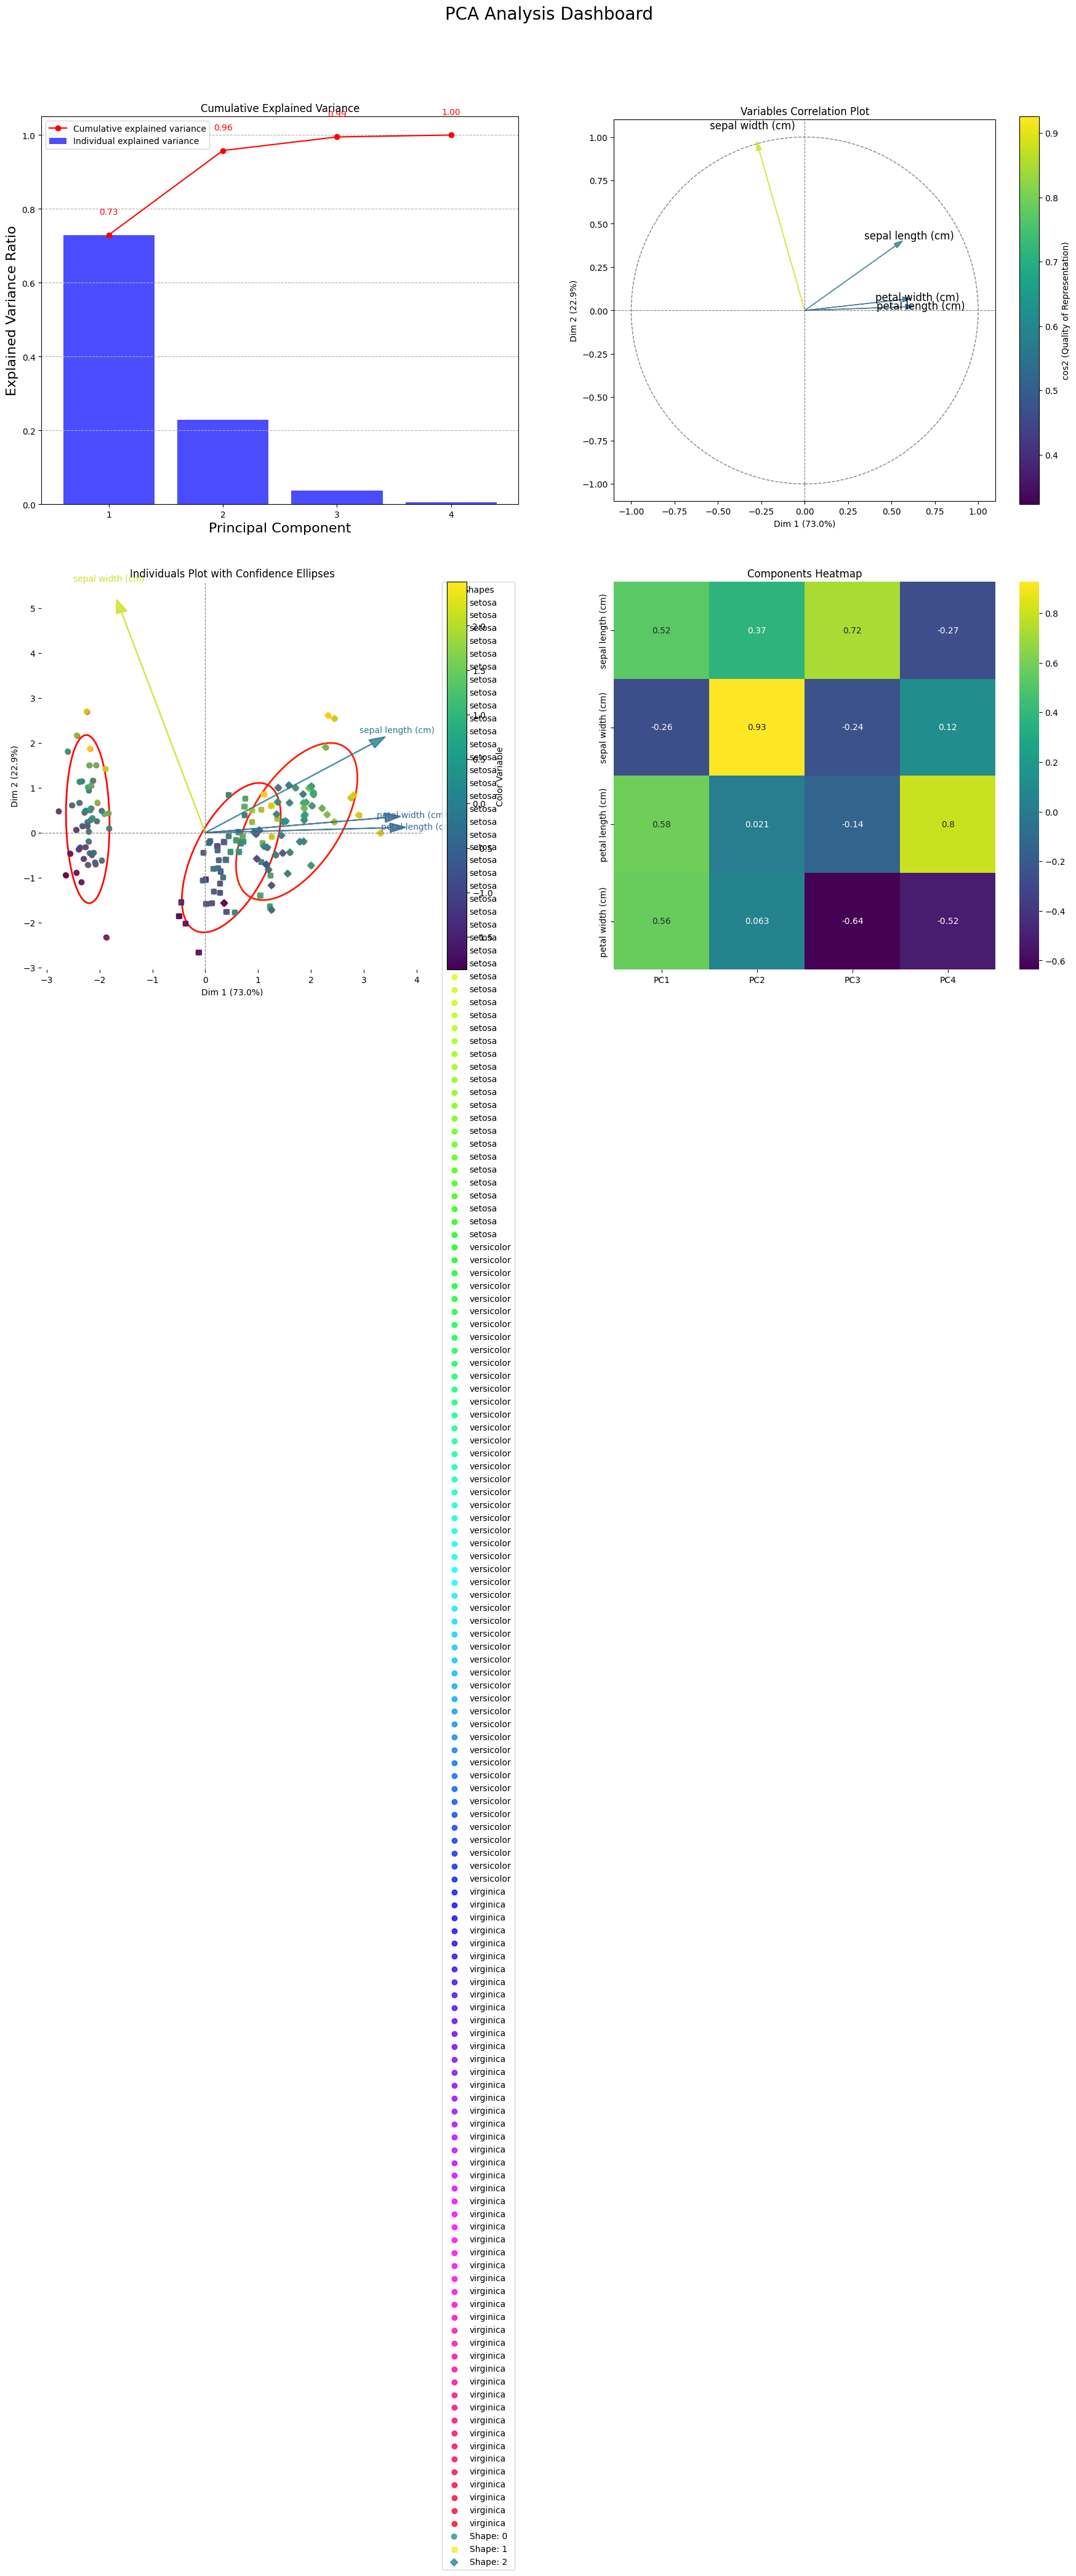

In [1]:
from sklearn.datasets import load_iris
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
m=bi()
m.data('iris.csv', sep=',') # Data is already scaled
m.data_on_model = dict(
    X=jnp.array(m.df.iloc[:,0:-2].values)
)
m.fit(m.models.pca(type="ARD")) # or robust, sparse, classic, sparse_robust_ard
m.models.pca.plot(
    X=m.df.iloc[:,0:-2].values,
    y=m.df.iloc[:,-2].values, 
    feature_names=m.df.columns[0:-2], 
    target_names=m.df.iloc[:,-1].values,
    color_var=m.df.iloc[:,0].values,
    shape_var=m.df.iloc[:,-2].values
)

In [11]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import numpy as np # For plotting compatibility
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
import matplotlib.pyplot as plt

m = bi(platform='cpu')


# --- Load and Scale Data (from scratch with JAX) ---
iris = load_iris()
X_raw = jnp.array(iris.data)
y = jnp.array(iris.target)
feature_names = iris.feature_names
target_names = iris.target_names
def scale_data(X):
    """Standardizes features by removing the mean and scaling to unit variance."""
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std, mean, std

X_scaled, data_mean, data_std = scale_data(X_raw)
X_scaled.shape

jax.local_device_count 16


(150, 4)

sample: 100%|██████████| 1000/1000 [00:09<00:00, 108.60it/s, 255 steps of size 2.88e-02. acc. prob=0.88]
/home/sosa/work/BI/BI/Models/PCA.py:417: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(indices, cumulative, 'ro-', color=color_cumulative_line, label='Cumulative explained variance')


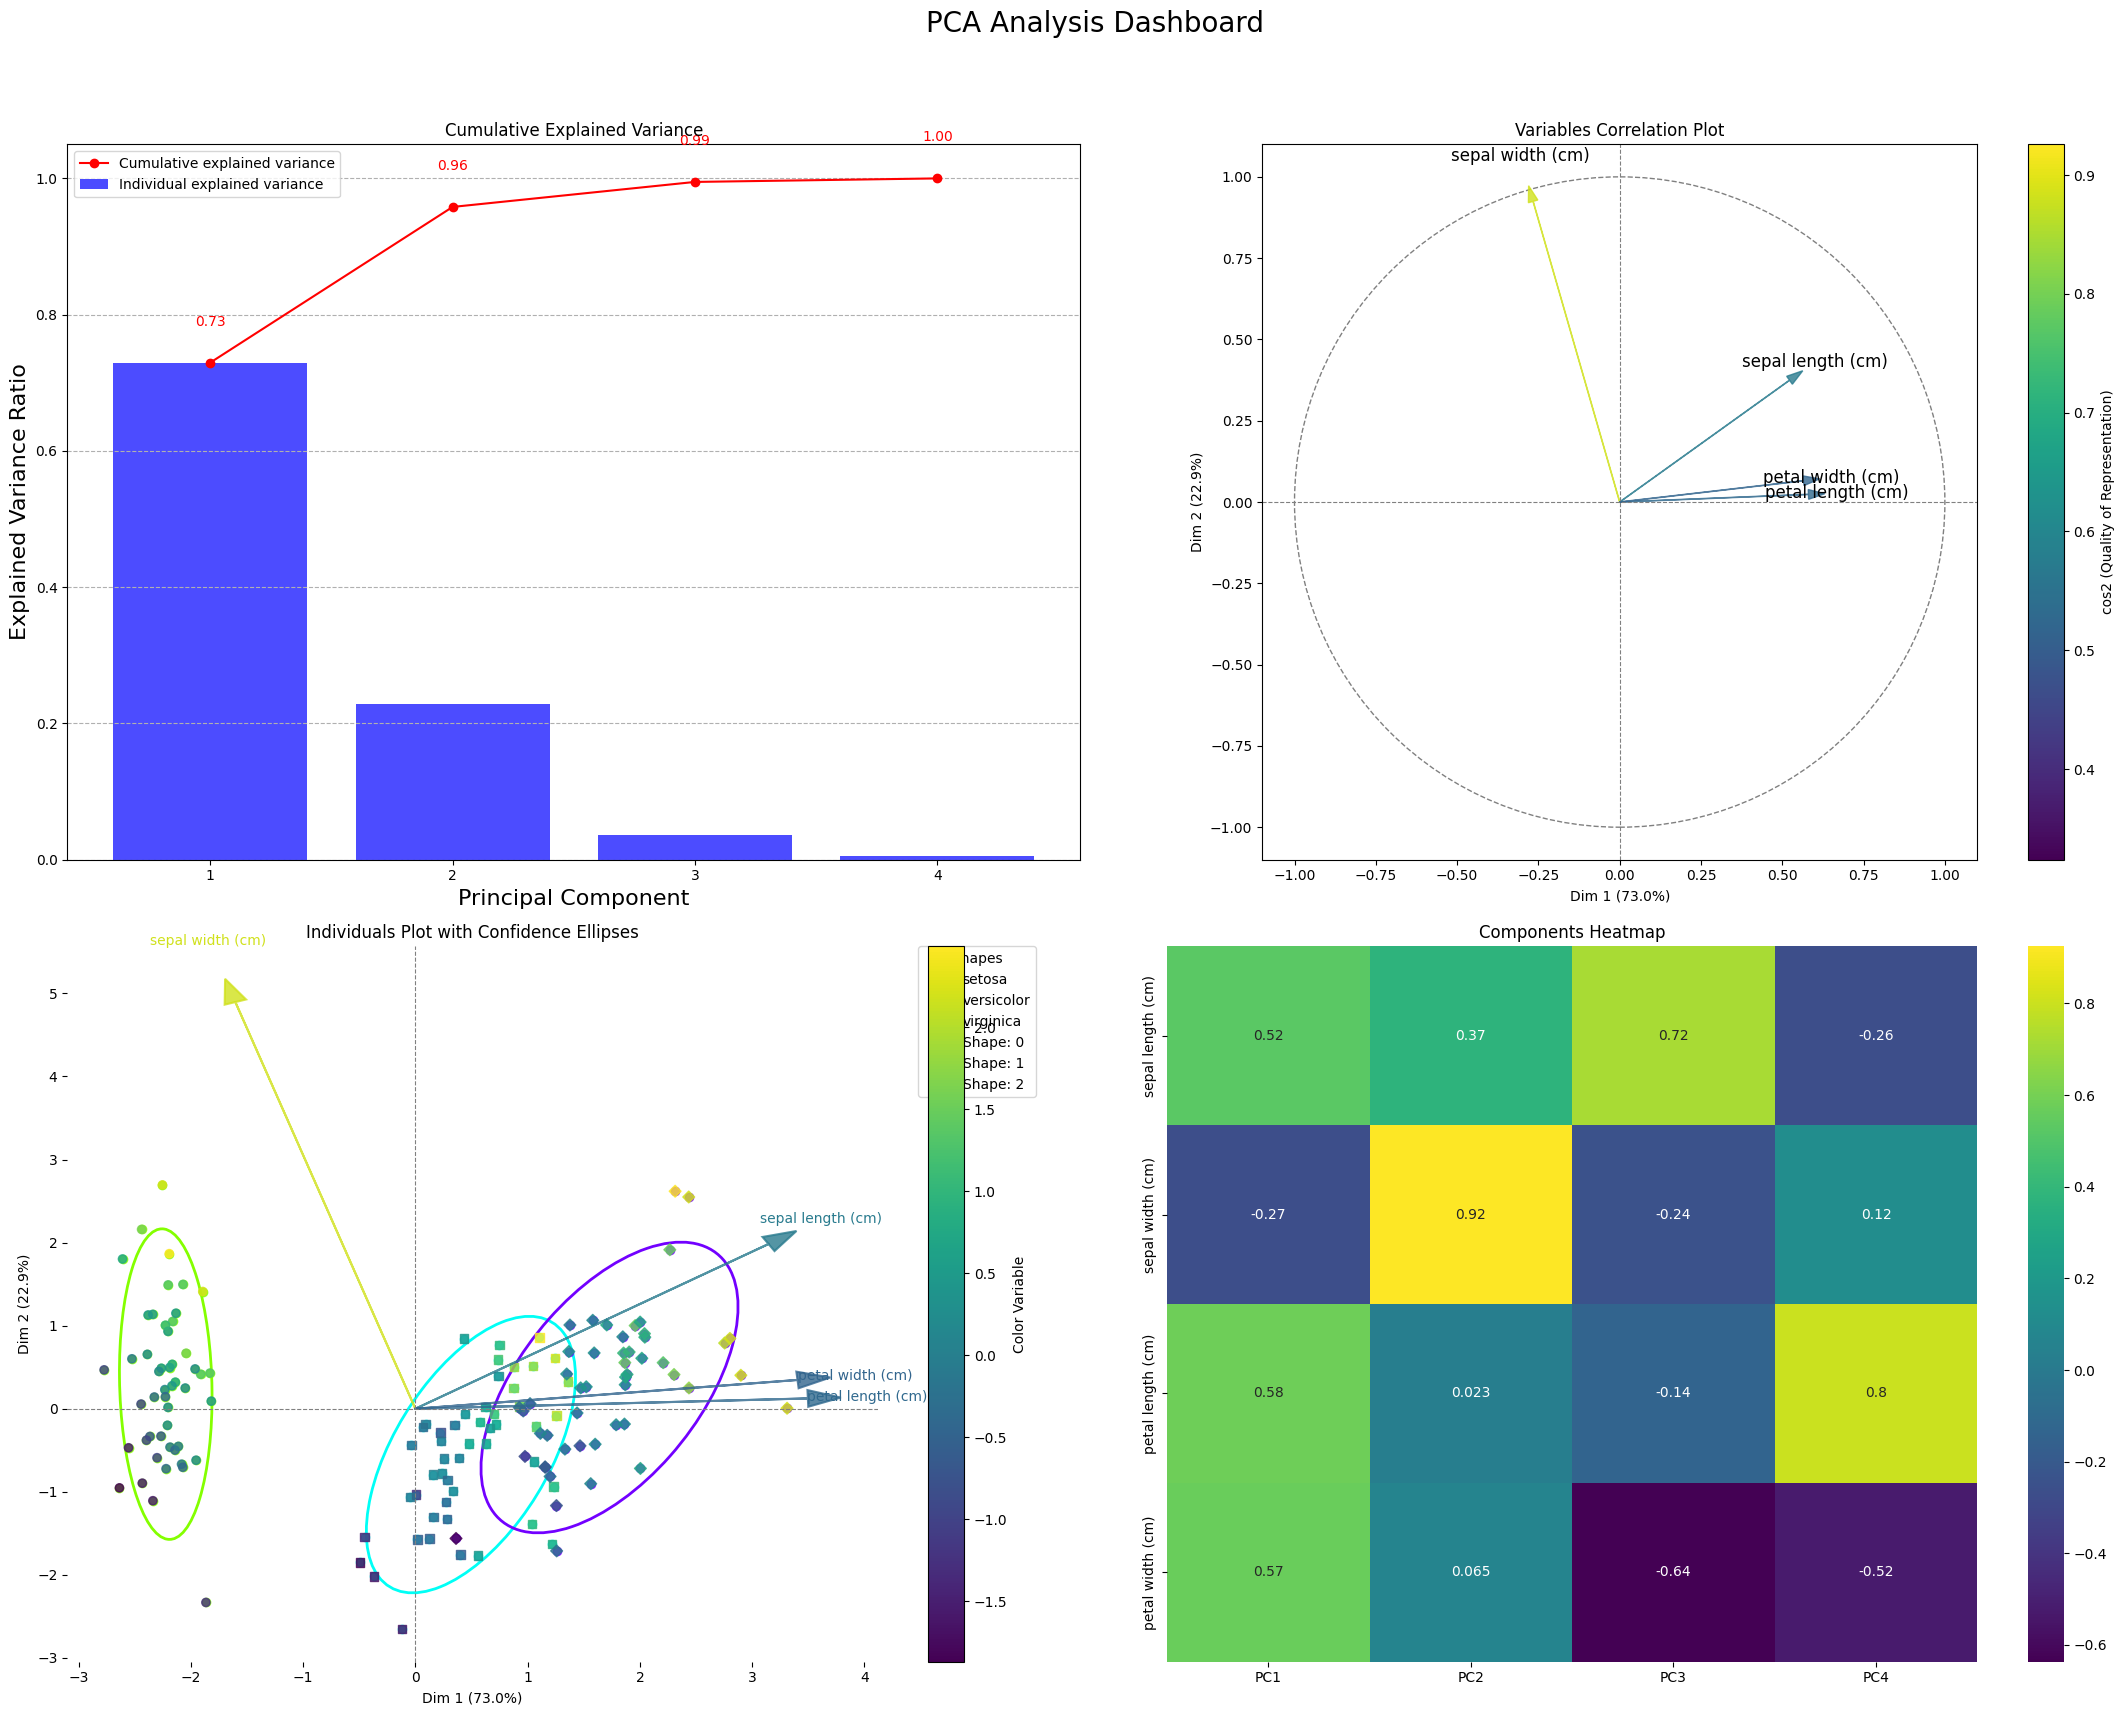

In [ ]:
m.data_on_model = dict(X=X_scaled)
m.fit(m.models.pca())
m.models.pca.plot(
    X=X_scaled,
    y=y, 
    feature_names=feature_names, 
    target_names=target_names,
    color_var=X_scaled[:,0],
    shape_var=y
)

/home/sosa/work/BI/BI/Models/PCA.py:384: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(indices, cumulative, 'ro-', color=color_cumulative_line, label='Cumulative explained variance')


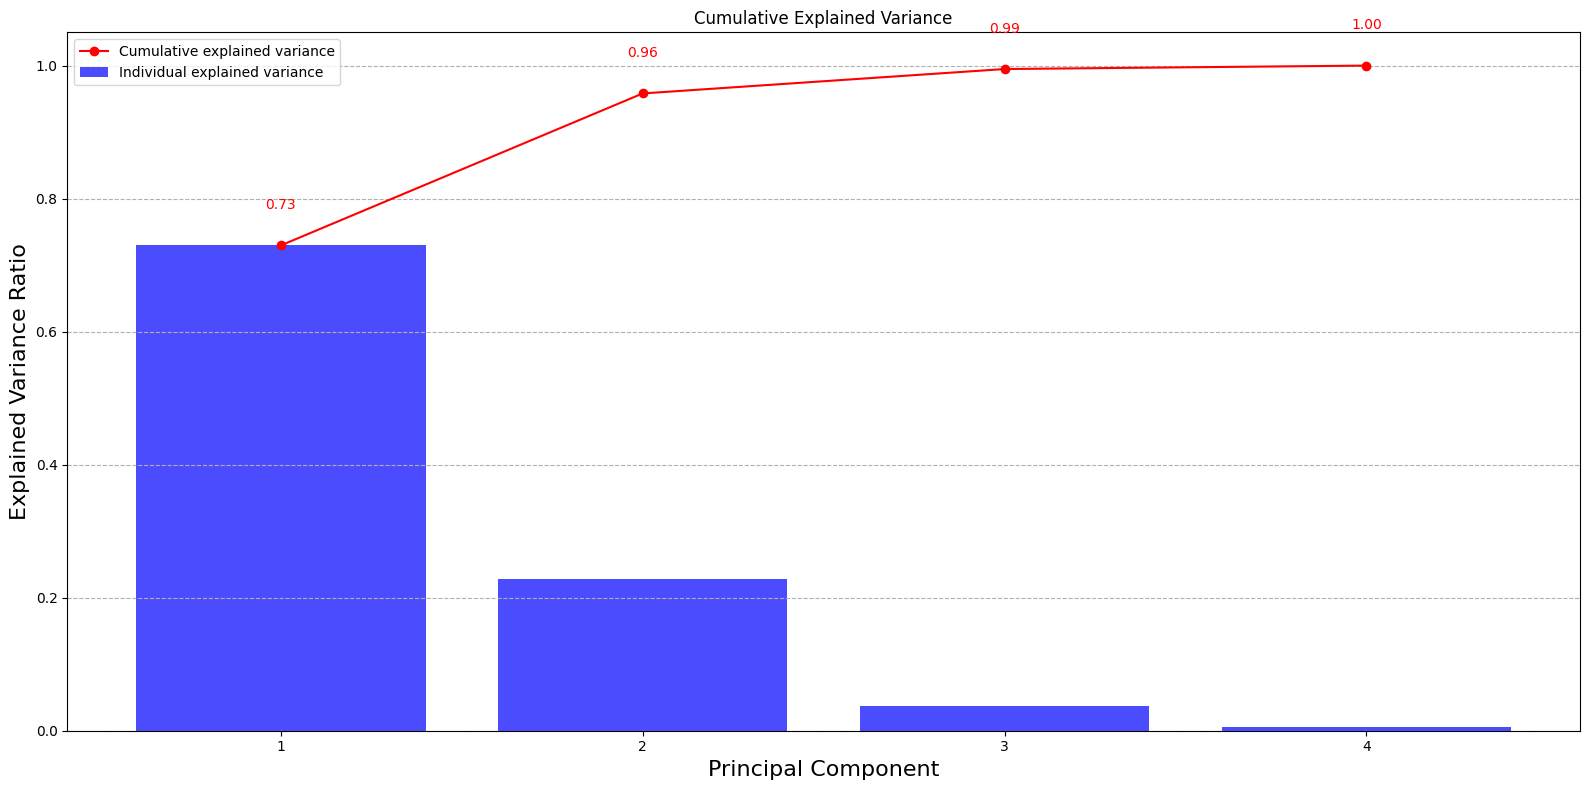

In [3]:
m.models.pca.cumulative_variance(X_scaled)

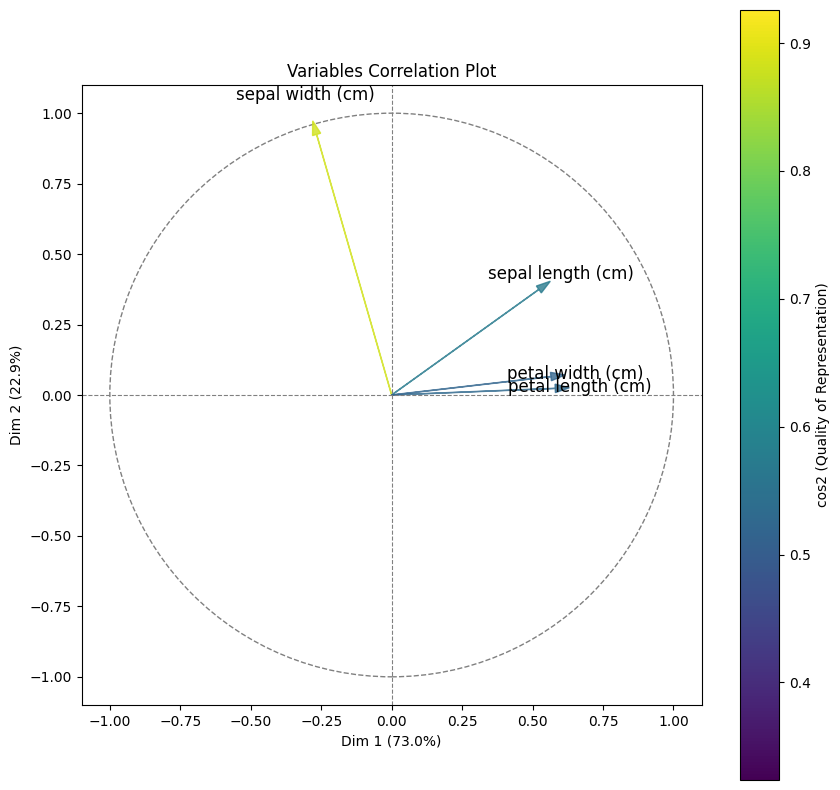

In [4]:
m.models.pca.variable_correlation(feature_names)

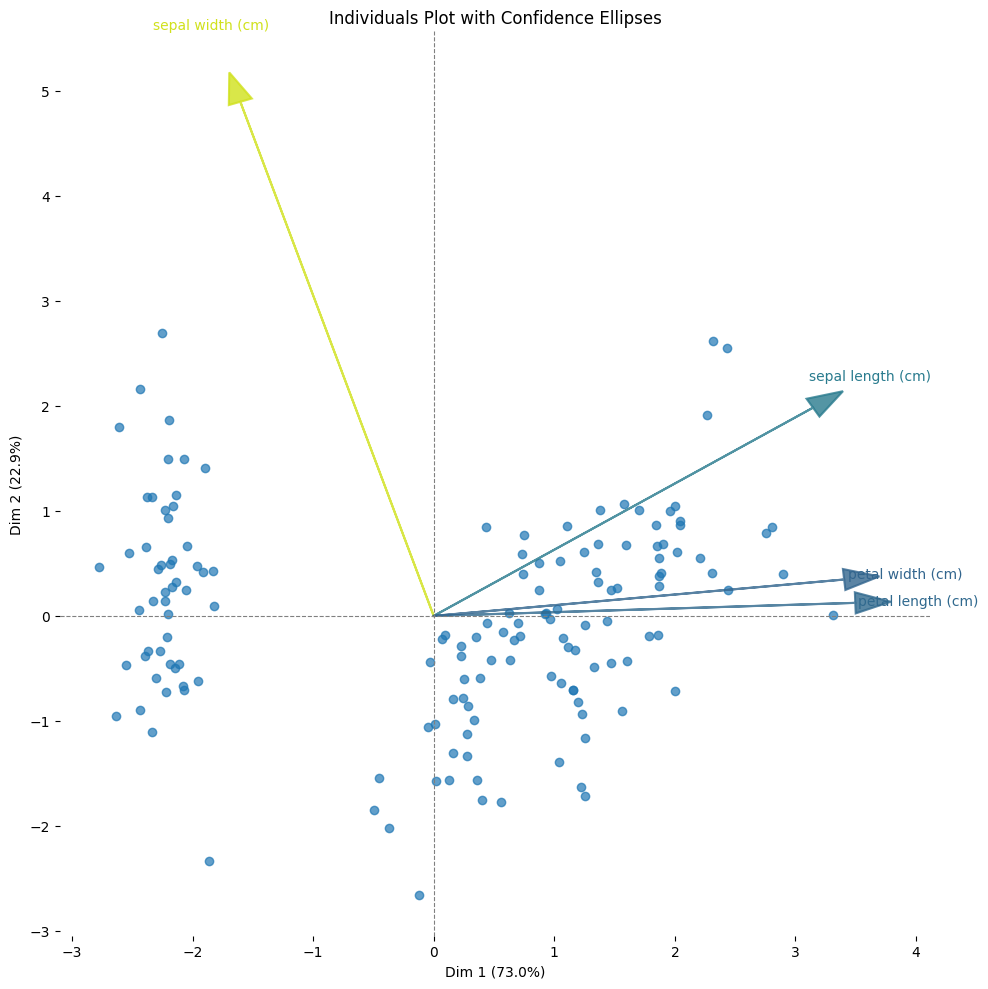

<Axes: title={'center': 'Individuals Plot with Confidence Ellipses'}, xlabel='Dim 1 (73.0%)', ylabel='Dim 2 (22.9%)'>

In [10]:
m.models.pca.individual_correlation(feature_names=feature_names)

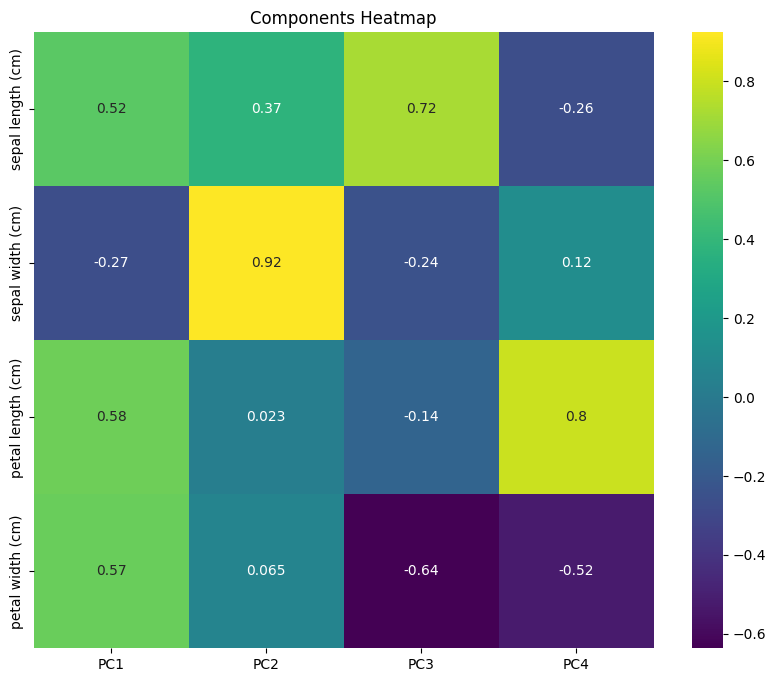

In [6]:
m.models.pca.components(feature_names=feature_names)

# Comparing sklearn results

In [8]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(X_scaled)

,n_components,4
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


<Axes: >

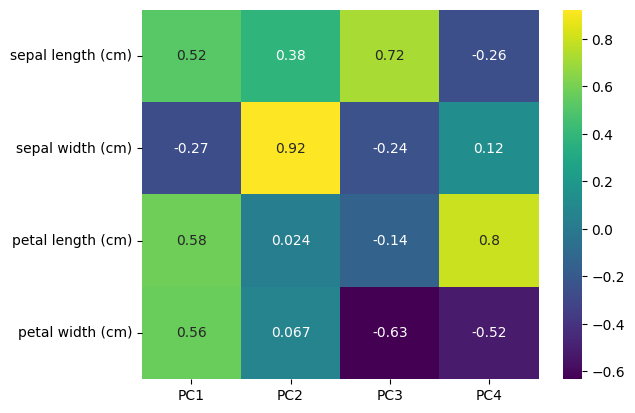

In [9]:
sklearn_comps = pca.components_.T
pc_names = [f'PC{i+1}' for i in range(sklearn_comps.shape[1])]
df_sklearn = pd.DataFrame(sklearn_comps, index=feature_names, columns=pc_names)
sns.heatmap(df_sklearn, annot=True, cmap='viridis')

# PCA variants

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:21<00:00, 46.68it/s, 511 steps of size 1.46e-02. acc. prob=0.89]


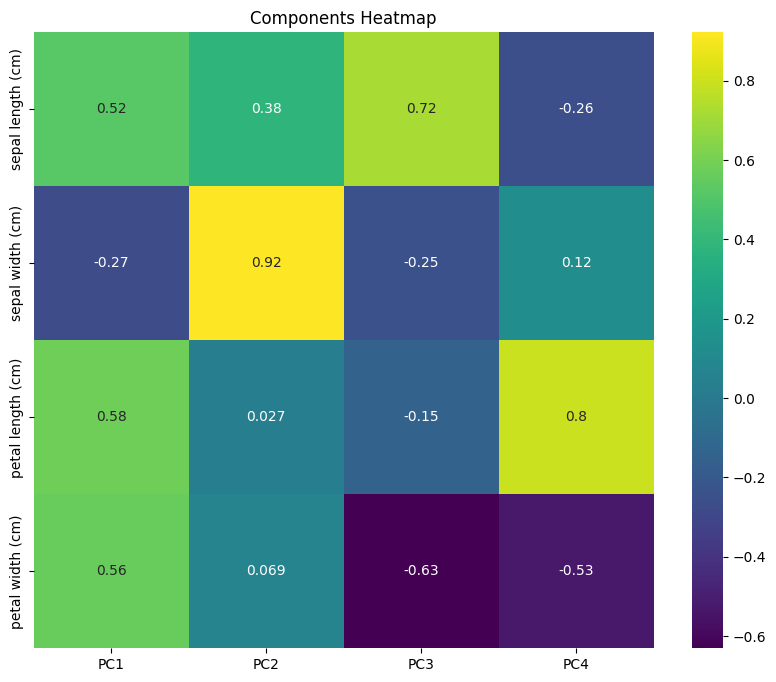

In [10]:
m = bi(platform='cpu')
m.data_on_model = dict(X=X_scaled)
m.fit(m.models.pca(type='robust'))
m.models.pca.components(feature_names=feature_names)

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:12<00:00, 77.40it/s, 255 steps of size 2.14e-02. acc. prob=0.89]


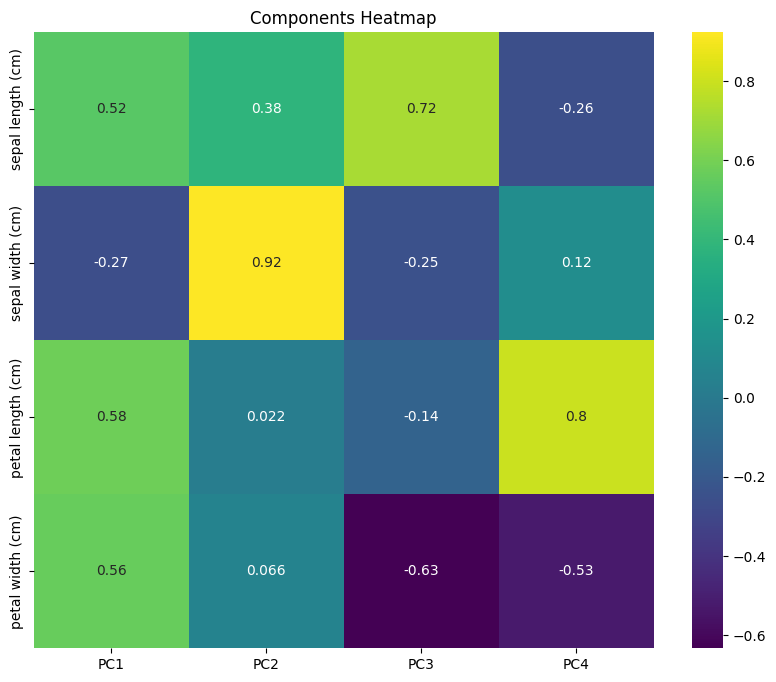

In [11]:
m = bi(platform='cpu')
m.data_on_model = dict(X=X_scaled)
m.fit(m.models.pca(type='sparse'))
m.models.pca.components(feature_names=feature_names)

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:13<00:00, 75.89it/s, 511 steps of size 1.49e-02. acc. prob=0.86] 


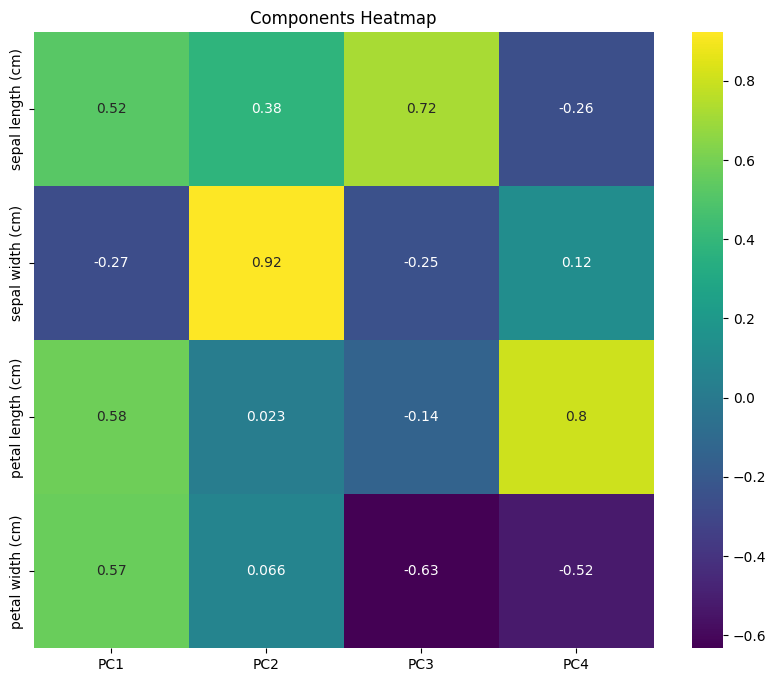

In [12]:
m = bi(platform='cpu')
m.data_on_model = dict(X=X_scaled)
m.fit(m.models.pca(type='classic'))
m.models.pca.components(feature_names=feature_names)

jax.local_device_count 16


sample: 100%|██████████| 1000/1000 [00:21<00:00, 45.53it/s, 255 steps of size 1.46e-02. acc. prob=0.90]


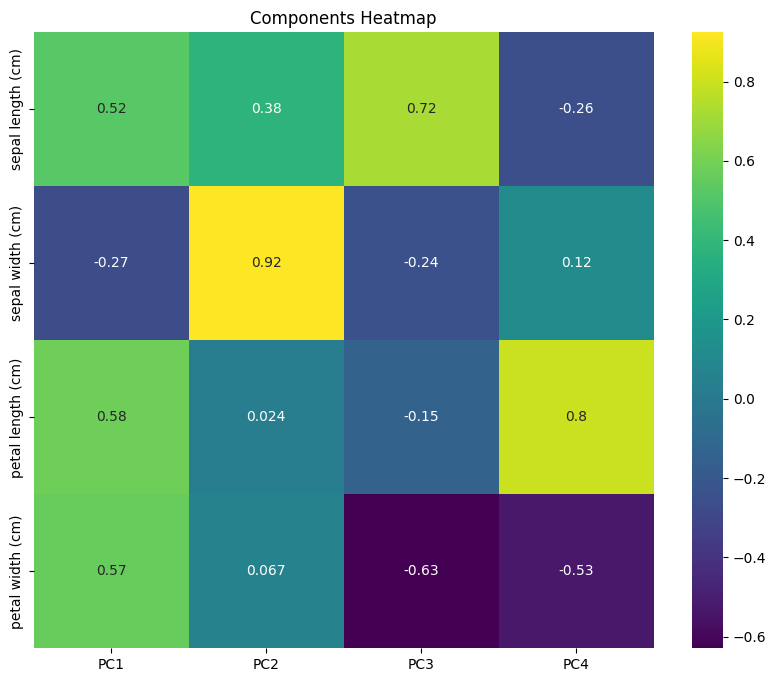

In [13]:
m = bi(platform='cpu')
m.data_on_model = dict(X=X_scaled)
m.fit(m.models.pca(type='sparse_robust_ard'))
m.models.pca.components(feature_names=feature_names)

# References
https://www.tensorflow.org/probability/examples/Probabilistic_PCA

<a name='1'></a>[1]: Michael E. Tipping and Christopher M. Bishop. Probabilistic principal component analysis. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 61(3): 611-622, 1999.